In [1]:
import os
for dirname, _, filenames in os.walk('OS_Collected_Data'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [3]:
import os
import pandas as pd

healthy_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/normal',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/normal/normal',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Normal',
    r'/kaggle/input/osteoporosis/osteoporosis/normal'
]


osteoporosis_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Osteoporosis',
    r'/kaggle/input/osteoporosis/osteoporosis/osteoporosis'
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, osteoporosis_dirs]
class_labels = ['Healthy', 'Osteoporosis']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)
knee_osteoporosis_df = pd.DataFrame(knee_osteoporosis_data)
print(knee_osteoporosis_df.head())
print(knee_osteoporosis_df["labels"].value_counts())


                                           filepaths   labels
0  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
1  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
2  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
3  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
4  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
labels
Osteoporosis    793
Healthy         780
Name: count, dtype: int64


In [4]:
knee_osteoporosis_df.shape

(1573, 2)

In [5]:
train_images, test_images = train_test_split(knee_osteoporosis_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(knee_osteoporosis_df, test_size=0.2, random_state=42)

In [6]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(1258, 2)
(472, 2)
(315, 2)
(1101, 2)


In [7]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 1258 validated image filenames belonging to 2 classes.
Found 472 validated image filenames belonging to 2 classes.
Found 315 validated image filenames belonging to 2 classes.


In [8]:
classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Osteoporosis']


In [9]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

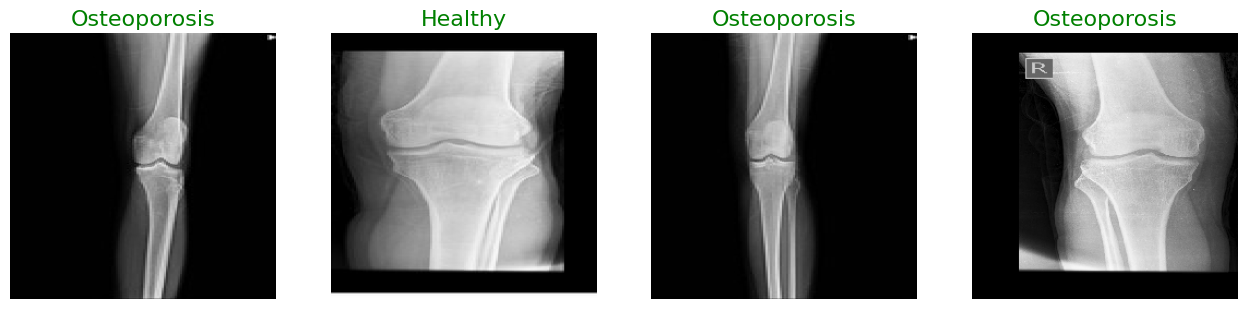

In [10]:
show_knee_images(train)

In [11]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from keras.models import Model
from keras.applications.vgg19 import VGG19
import tensorflow as tf

vgg19_weights = '/kaggle/input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels.h5'
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create the custom model by adding layers
x = vgg19_model.output

# Add your custom layers according to your specified architecture
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Dropout(0.5)(x) 
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = Dropout(0.5)(x) 
x = Conv2D(512, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Flatten()(x)

x = Dense(4096, activation="relu")(x)
x = Dense(4096, activation="relu")(x)
x = Dense(4096, activation="relu")(x)

output = Dense(2, activation="sigmoid")(x)

# Create the custom model
model = Model(inputs=vgg19_model.input, outputs=output)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()


80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [12]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10


2023-11-12 07:30:55.220590: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


315/315 [==============================] - 46s 105ms/step - loss: 0.6933 - accuracy: 0.5008 - val_loss: 0.7306 - val_accuracy: 0.4667
Epoch 2/10
315/315 [==============================] - 28s 90ms/step - loss: 0.6930 - accuracy: 0.5111 - val_loss: 0.7289 - val_accuracy: 0.4667
Epoch 3/10
315/315 [==============================] - 28s 89ms/step - loss: 0.6932 - accuracy: 0.5103 - val_loss: 0.7109 - val_accuracy: 0.4667
Epoch 4/10
315/315 [==============================] - 28s 89ms/step - loss: 0.6929 - accuracy: 0.5111 - val_loss: 0.6971 - val_accuracy: 0.4698
Epoch 5/10
315/315 [==============================] - 28s 90ms/step - loss: 0.6930 - accuracy: 0.5111 - val_loss: 0.6918 - val_accuracy: 0.4730
Epoch 6/10
315/315 [==============================] - 28s 90ms/step - loss: 0.6927 - accuracy: 0.5111 - val_loss: 0.6888 - val_accuracy: 0.4762
Epoch 7/10
315/315 [==============================] - 28s 89ms/step - loss: 0.6926 - accuracy: 0.5111 - val_loss: 0.6883 - val_accuracy: 0.4762
Ep

In [13]:
history1 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
315/315 [==============================] - 28s 89ms/step - loss: 0.6903 - accuracy: 0.5111 - val_loss: 0.6859 - val_accuracy: 0.4762
Epoch 2/10
315/315 [==============================] - 28s 89ms/step - loss: 0.6884 - accuracy: 0.5111 - val_loss: 0.6840 - val_accuracy: 0.4762
Epoch 3/10
315/315 [==============================] - 28s 89ms/step - loss: 0.6851 - accuracy: 0.5127 - val_loss: 0.6799 - val_accuracy: 0.6317
Epoch 4/10
315/315 [==============================] - 28s 89ms/step - loss: 0.6796 - accuracy: 0.5390 - val_loss: 0.6753 - val_accuracy: 0.5873
Epoch 5/10
315/315 [==============================] - 28s 89ms/step - loss: 0.6663 - accuracy: 0.5922 - val_loss: 0.6648 - val_accuracy: 0.6254
Epoch 6/10
315/315 [==============================] - 28s 89ms/step - loss: 0.6500 - accuracy: 0.6574 - val_loss: 0.6650 - val_accuracy: 0.6095
Epoch 7/10
315/315 [==============================] - 28s 89ms/step - loss: 0.6353 - accuracy: 0.7035 - val_loss: 0.6480 - val_accuracy:

In [14]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 50ms/step - loss: 0.5904 - accuracy: 0.7606


[0.5903506278991699, 0.7605932354927063]

In [15]:
history2 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
315/315 [==============================] - 28s 90ms/step - loss: 0.5848 - accuracy: 0.7528 - val_loss: 0.6095 - val_accuracy: 0.6889
Epoch 2/10
315/315 [==============================] - 28s 89ms/step - loss: 0.5714 - accuracy: 0.7464 - val_loss: 0.5856 - val_accuracy: 0.7238
Epoch 3/10
315/315 [==============================] - 28s 89ms/step - loss: 0.5546 - accuracy: 0.7583 - val_loss: 0.5694 - val_accuracy: 0.7460
Epoch 4/10
315/315 [==============================] - 28s 89ms/step - loss: 0.5538 - accuracy: 0.7591 - val_loss: 0.7586 - val_accuracy: 0.5365
Epoch 5/10
315/315 [==============================] - 28s 89ms/step - loss: 0.5494 - accuracy: 0.7711 - val_loss: 0.5560 - val_accuracy: 0.7587
Epoch 6/10
315/315 [==============================] - 28s 90ms/step - loss: 0.5331 - accuracy: 0.7695 - val_loss: 0.5559 - val_accuracy: 0.7270
Epoch 7/10
315/315 [==============================] - 28s 89ms/step - loss: 0.5218 - accuracy: 0.7742 - val_loss: 0.5382 - val_accuracy:

In [16]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 51ms/step - loss: 0.4885 - accuracy: 0.7860


[0.48853787779808044, 0.7860169410705566]

In [17]:
history3 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
315/315 [==============================] - 28s 89ms/step - loss: 0.4888 - accuracy: 0.7742 - val_loss: 0.5415 - val_accuracy: 0.7619
Epoch 2/10
315/315 [==============================] - 28s 89ms/step - loss: 0.4802 - accuracy: 0.7941 - val_loss: 0.6316 - val_accuracy: 0.7238
Epoch 3/10
315/315 [==============================] - 28s 89ms/step - loss: 0.4667 - accuracy: 0.7957 - val_loss: 0.5332 - val_accuracy: 0.7460
Epoch 4/10
315/315 [==============================] - 28s 89ms/step - loss: 0.4735 - accuracy: 0.7989 - val_loss: 0.5039 - val_accuracy: 0.7587
Epoch 5/10
315/315 [==============================] - 28s 89ms/step - loss: 0.4471 - accuracy: 0.8219 - val_loss: 0.4802 - val_accuracy: 0.7746
Epoch 6/10
315/315 [==============================] - 28s 89ms/step - loss: 0.4390 - accuracy: 0.8140 - val_loss: 0.4561 - val_accuracy: 0.7905
Epoch 7/10
315/315 [==============================] - 28s 89ms/step - loss: 0.4445 - accuracy: 0.8148 - val_loss: 0.5142 - val_accuracy:

In [18]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 50ms/step - loss: 0.4288 - accuracy: 0.8157


[0.42875394225120544, 0.8156779408454895]

In [19]:
history4 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
315/315 [==============================] - 28s 90ms/step - loss: 0.4056 - accuracy: 0.8275 - val_loss: 0.4582 - val_accuracy: 0.7810
Epoch 2/10
315/315 [==============================] - 28s 89ms/step - loss: 0.3946 - accuracy: 0.8490 - val_loss: 0.4311 - val_accuracy: 0.8222
Epoch 3/10
315/315 [==============================] - 28s 89ms/step - loss: 0.3798 - accuracy: 0.8426 - val_loss: 0.5757 - val_accuracy: 0.7397
Epoch 4/10
315/315 [==============================] - 28s 89ms/step - loss: 0.3827 - accuracy: 0.8529 - val_loss: 0.4032 - val_accuracy: 0.8190
Epoch 5/10
315/315 [==============================] - 28s 89ms/step - loss: 0.3644 - accuracy: 0.8537 - val_loss: 0.4086 - val_accuracy: 0.8476
Epoch 6/10
315/315 [==============================] - 28s 89ms/step - loss: 0.3513 - accuracy: 0.8577 - val_loss: 0.3862 - val_accuracy: 0.8476
Epoch 7/10
315/315 [==============================] - 28s 89ms/step - loss: 0.3469 - accuracy: 0.8609 - val_loss: 0.4925 - val_accuracy:

In [20]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 50ms/step - loss: 0.3615 - accuracy: 0.8644


[0.36150094866752625, 0.8644067645072937]

In [21]:
history5 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
315/315 [==============================] - 28s 89ms/step - loss: 0.2973 - accuracy: 0.8871 - val_loss: 0.3885 - val_accuracy: 0.8381
Epoch 2/10
315/315 [==============================] - 28s 89ms/step - loss: 0.2969 - accuracy: 0.8855 - val_loss: 0.3287 - val_accuracy: 0.8635
Epoch 3/10
315/315 [==============================] - 28s 89ms/step - loss: 0.2738 - accuracy: 0.8967 - val_loss: 0.3121 - val_accuracy: 0.8794
Epoch 4/10
315/315 [==============================] - 28s 89ms/step - loss: 0.2529 - accuracy: 0.9126 - val_loss: 0.3441 - val_accuracy: 0.8667
Epoch 5/10
315/315 [==============================] - 28s 89ms/step - loss: 0.2648 - accuracy: 0.9006 - val_loss: 0.3245 - val_accuracy: 0.8762
Epoch 6/10
315/315 [==============================] - 28s 89ms/step - loss: 0.2709 - accuracy: 0.9038 - val_loss: 0.2975 - val_accuracy: 0.8984
Epoch 7/10
315/315 [==============================] - 28s 89ms/step - loss: 0.2539 - accuracy: 0.9062 - val_loss: 0.3901 - val_accuracy:

In [22]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 49ms/step - loss: 0.2532 - accuracy: 0.8983


[0.253157377243042, 0.8983050584793091]

In [23]:
history6 = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
315/315 [==============================] - 28s 89ms/step - loss: 0.2329 - accuracy: 0.9141 - val_loss: 0.3602 - val_accuracy: 0.8698
Epoch 2/10
315/315 [==============================] - 28s 89ms/step - loss: 0.2092 - accuracy: 0.9229 - val_loss: 0.2956 - val_accuracy: 0.8984
Epoch 3/10
315/315 [==============================] - 28s 89ms/step - loss: 0.2146 - accuracy: 0.9213 - val_loss: 0.3499 - val_accuracy: 0.8730
Epoch 4/10
315/315 [==============================] - 28s 89ms/step - loss: 0.2132 - accuracy: 0.9149 - val_loss: 0.3311 - val_accuracy: 0.8857
Epoch 5/10
315/315 [==============================] - 28s 88ms/step - loss: 0.2190 - accuracy: 0.9149 - val_loss: 0.2619 - val_accuracy: 0.8984
Epoch 6/10
315/315 [==============================] - 28s 88ms/step - loss: 0.2011 - accuracy: 0.9253 - val_loss: 0.3221 - val_accuracy: 0.8698
Epoch 7/10
315/315 [==============================] - 28s 89ms/step - loss: 0.1873 - accuracy: 0.9324 - val_loss: 0.2984 - val_accuracy:

In [24]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 51ms/step - loss: 0.2456 - accuracy: 0.9047


[0.24555052816867828, 0.9046609997749329]

In [25]:
history7 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 88ms/step - loss: 0.1773 - accuracy: 0.9404 - val_loss: 0.2427 - val_accuracy: 0.9143
Epoch 2/5
315/315 [==============================] - 28s 89ms/step - loss: 0.1674 - accuracy: 0.9380 - val_loss: 0.2431 - val_accuracy: 0.9048
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.1575 - accuracy: 0.9444 - val_loss: 0.2838 - val_accuracy: 0.8952
Epoch 4/5
315/315 [==============================] - 28s 88ms/step - loss: 0.1729 - accuracy: 0.9293 - val_loss: 0.2823 - val_accuracy: 0.8825
Epoch 5/5
315/315 [==============================] - 28s 89ms/step - loss: 0.1823 - accuracy: 0.9300 - val_loss: 0.3097 - val_accuracy: 0.8952


In [26]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 50ms/step - loss: 0.2623 - accuracy: 0.9110


[0.2623412311077118, 0.9110169410705566]

In [27]:
history8 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 89ms/step - loss: 0.1656 - accuracy: 0.9356 - val_loss: 0.2294 - val_accuracy: 0.9111
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.1417 - accuracy: 0.9491 - val_loss: 0.2133 - val_accuracy: 0.8825
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.1180 - accuracy: 0.9515 - val_loss: 0.2033 - val_accuracy: 0.9429


In [28]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 49ms/step - loss: 0.1814 - accuracy: 0.9513


[0.18135863542556763, 0.9512711763381958]

In [29]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9513-01813.h5")

In [30]:
history8 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 88ms/step - loss: 0.1250 - accuracy: 0.9475 - val_loss: 0.2066 - val_accuracy: 0.9048
Epoch 2/5
315/315 [==============================] - 28s 89ms/step - loss: 0.1574 - accuracy: 0.9436 - val_loss: 0.2472 - val_accuracy: 0.8921
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.1186 - accuracy: 0.9531 - val_loss: 0.1724 - val_accuracy: 0.9175
Epoch 4/5
315/315 [==============================] - 28s 89ms/step - loss: 0.1090 - accuracy: 0.9634 - val_loss: 0.1574 - val_accuracy: 0.9460
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.1335 - accuracy: 0.9404 - val_loss: 0.2041 - val_accuracy: 0.9111


In [31]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 48ms/step - loss: 0.1662 - accuracy: 0.9301


[0.1661723405122757, 0.930084764957428]

In [32]:
history9 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 89ms/step - loss: 0.1016 - accuracy: 0.9555 - val_loss: 0.6851 - val_accuracy: 0.7587
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.1128 - accuracy: 0.9515 - val_loss: 0.2496 - val_accuracy: 0.8921
Epoch 3/5
315/315 [==============================] - 28s 89ms/step - loss: 0.1342 - accuracy: 0.9428 - val_loss: 0.1930 - val_accuracy: 0.9079
Epoch 4/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0953 - accuracy: 0.9642 - val_loss: 0.1386 - val_accuracy: 0.9524
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0885 - accuracy: 0.9610 - val_loss: 0.1607 - val_accuracy: 0.9270


In [33]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 48ms/step - loss: 0.1329 - accuracy: 0.9407


[0.13288861513137817, 0.9406779408454895]

In [34]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9406-01328.h5")

In [35]:
history10 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0920 - accuracy: 0.9618 - val_loss: 0.1869 - val_accuracy: 0.9175
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.1132 - accuracy: 0.9555 - val_loss: 0.1380 - val_accuracy: 0.9397
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0895 - accuracy: 0.9618 - val_loss: 0.1501 - val_accuracy: 0.9270
Epoch 4/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0792 - accuracy: 0.9634 - val_loss: 0.1343 - val_accuracy: 0.9429
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0726 - accuracy: 0.9642 - val_loss: 0.1344 - val_accuracy: 0.9270


In [36]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 48ms/step - loss: 0.1094 - accuracy: 0.9407


[0.10937193036079407, 0.9406779408454895]

In [37]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9406-01093.h5")

In [38]:
history11 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0830 - accuracy: 0.9603 - val_loss: 0.1801 - val_accuracy: 0.9079
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0812 - accuracy: 0.9579 - val_loss: 0.1959 - val_accuracy: 0.9016
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0800 - accuracy: 0.9634 - val_loss: 0.1620 - val_accuracy: 0.9302
Epoch 4/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0754 - accuracy: 0.9658 - val_loss: 0.1847 - val_accuracy: 0.9143
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0637 - accuracy: 0.9674 - val_loss: 0.1396 - val_accuracy: 0.9460


In [39]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 48ms/step - loss: 0.1135 - accuracy: 0.9513


[0.11348702758550644, 0.9512711763381958]

In [40]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9510-01134.h5")

In [41]:
history12 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0712 - accuracy: 0.9666 - val_loss: 0.1292 - val_accuracy: 0.9492
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0658 - accuracy: 0.9690 - val_loss: 0.1377 - val_accuracy: 0.9492
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0732 - accuracy: 0.9666 - val_loss: 0.1254 - val_accuracy: 0.9746
Epoch 4/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0620 - accuracy: 0.9642 - val_loss: 0.1318 - val_accuracy: 0.9397
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0619 - accuracy: 0.9690 - val_loss: 0.1325 - val_accuracy: 0.9429


In [42]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 50ms/step - loss: 0.1074 - accuracy: 0.9470


[0.10740793496370316, 0.9470338821411133]

In [43]:
history12 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0638 - accuracy: 0.9666 - val_loss: 0.1939 - val_accuracy: 0.9206
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0619 - accuracy: 0.9674 - val_loss: 0.1421 - val_accuracy: 0.9333
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0631 - accuracy: 0.9690 - val_loss: 0.1382 - val_accuracy: 0.9333
Epoch 4/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0577 - accuracy: 0.9690 - val_loss: 0.1312 - val_accuracy: 0.9333
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0573 - accuracy: 0.9658 - val_loss: 0.1319 - val_accuracy: 0.9302


In [44]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 49ms/step - loss: 0.1044 - accuracy: 0.9428


[0.10437574237585068, 0.9427965879440308]

In [45]:
history13 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0601 - accuracy: 0.9666 - val_loss: 0.1512 - val_accuracy: 0.9333
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0592 - accuracy: 0.9650 - val_loss: 0.1251 - val_accuracy: 0.9429
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.1083 - accuracy: 0.9531 - val_loss: 0.1494 - val_accuracy: 0.9429
Epoch 4/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0646 - accuracy: 0.9706 - val_loss: 0.1014 - val_accuracy: 0.9587
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0760 - accuracy: 0.9626 - val_loss: 0.1241 - val_accuracy: 0.9492


In [46]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 48ms/step - loss: 0.1017 - accuracy: 0.9534


[0.10165651887655258, 0.9533898234367371]

In [47]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9533-01016.h5")

In [48]:
history14 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0594 - accuracy: 0.9674 - val_loss: 0.1128 - val_accuracy: 0.9365
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0543 - accuracy: 0.9642 - val_loss: 0.1157 - val_accuracy: 0.9333
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0541 - accuracy: 0.9658 - val_loss: 0.1258 - val_accuracy: 0.9524
Epoch 4/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0896 - accuracy: 0.9555 - val_loss: 0.1564 - val_accuracy: 0.9143
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0566 - accuracy: 0.9674 - val_loss: 0.1081 - val_accuracy: 0.9333


In [49]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 48ms/step - loss: 0.0871 - accuracy: 0.9449


[0.08714985102415085, 0.944915235042572]

In [50]:
history15 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0584 - accuracy: 0.9722 - val_loss: 0.2156 - val_accuracy: 0.9143
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0616 - accuracy: 0.9626 - val_loss: 0.1088 - val_accuracy: 0.9524
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0569 - accuracy: 0.9666 - val_loss: 0.2142 - val_accuracy: 0.9143
Epoch 4/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0586 - accuracy: 0.9618 - val_loss: 0.1177 - val_accuracy: 0.9429
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0536 - accuracy: 0.9682 - val_loss: 0.1220 - val_accuracy: 0.9365


In [51]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 48ms/step - loss: 0.0955 - accuracy: 0.9470


[0.09553711116313934, 0.9470338821411133]

In [52]:
history16 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0542 - accuracy: 0.9674 - val_loss: 0.1242 - val_accuracy: 0.9429
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0505 - accuracy: 0.9706 - val_loss: 0.1428 - val_accuracy: 0.9333
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0522 - accuracy: 0.9690 - val_loss: 0.1138 - val_accuracy: 0.9302
Epoch 4/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0518 - accuracy: 0.9674 - val_loss: 0.1062 - val_accuracy: 0.9429
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0753 - accuracy: 0.9618 - val_loss: 0.1379 - val_accuracy: 0.9270


In [53]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 49ms/step - loss: 0.1079 - accuracy: 0.9407


[0.10788584500551224, 0.9406779408454895]

In [54]:
history17 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0526 - accuracy: 0.9690 - val_loss: 0.1229 - val_accuracy: 0.9460
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0496 - accuracy: 0.9682 - val_loss: 0.1019 - val_accuracy: 0.9556
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0508 - accuracy: 0.9698 - val_loss: 0.1168 - val_accuracy: 0.9460
Epoch 4/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0522 - accuracy: 0.9698 - val_loss: 0.1193 - val_accuracy: 0.9429
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0504 - accuracy: 0.9706 - val_loss: 0.1199 - val_accuracy: 0.9492


In [55]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 48ms/step - loss: 0.0960 - accuracy: 0.9534


[0.09599112719297409, 0.9533898234367371]

In [56]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9533-00959.h5")

In [57]:
history18 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0498 - accuracy: 0.9698 - val_loss: 0.1319 - val_accuracy: 0.9302
Epoch 2/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0520 - accuracy: 0.9714 - val_loss: 0.0884 - val_accuracy: 0.9746
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0559 - accuracy: 0.9682 - val_loss: 0.1058 - val_accuracy: 0.9587
Epoch 4/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0488 - accuracy: 0.9698 - val_loss: 0.1029 - val_accuracy: 0.9714
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0512 - accuracy: 0.9666 - val_loss: 0.1167 - val_accuracy: 0.9587


In [58]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 48ms/step - loss: 0.0928 - accuracy: 0.9597


[0.09277220815420151, 0.9597457647323608]

In [59]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9597-00927.h5")

In [60]:
history19 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0480 - accuracy: 0.9698 - val_loss: 0.1335 - val_accuracy: 0.9365
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0466 - accuracy: 0.9706 - val_loss: 0.1087 - val_accuracy: 0.9460
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0455 - accuracy: 0.9714 - val_loss: 0.1529 - val_accuracy: 0.9333
Epoch 4/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0476 - accuracy: 0.9682 - val_loss: 0.1358 - val_accuracy: 0.9365
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0454 - accuracy: 0.9738 - val_loss: 0.1823 - val_accuracy: 0.9111


In [61]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 49ms/step - loss: 0.1354 - accuracy: 0.9343


[0.13540636003017426, 0.9343220591545105]

In [62]:
history20 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0481 - accuracy: 0.9722 - val_loss: 0.1084 - val_accuracy: 0.9524
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0514 - accuracy: 0.9706 - val_loss: 0.1345 - val_accuracy: 0.9460
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0492 - accuracy: 0.9682 - val_loss: 0.1127 - val_accuracy: 0.9460
Epoch 4/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0566 - accuracy: 0.9658 - val_loss: 0.1401 - val_accuracy: 0.9270
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0494 - accuracy: 0.9682 - val_loss: 0.1194 - val_accuracy: 0.9397


In [63]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 51ms/step - loss: 0.0938 - accuracy: 0.9513


[0.0938182845711708, 0.9512711763381958]

In [64]:
history21 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0468 - accuracy: 0.9722 - val_loss: 0.1072 - val_accuracy: 0.9587
Epoch 2/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0472 - accuracy: 0.9690 - val_loss: 0.1175 - val_accuracy: 0.9460
Epoch 3/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0473 - accuracy: 0.9762 - val_loss: 0.1061 - val_accuracy: 0.9492
Epoch 4/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0485 - accuracy: 0.9682 - val_loss: 0.1066 - val_accuracy: 0.9460
Epoch 5/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0454 - accuracy: 0.9714 - val_loss: 0.1049 - val_accuracy: 0.9429


In [65]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 50ms/step - loss: 0.0841 - accuracy: 0.9513


[0.08405910432338715, 0.9512711763381958]

In [66]:
history22 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0460 - accuracy: 0.9682 - val_loss: 0.1376 - val_accuracy: 0.9270
Epoch 2/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0443 - accuracy: 0.9706 - val_loss: 0.1054 - val_accuracy: 0.9556
Epoch 3/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0478 - accuracy: 0.9690 - val_loss: 0.1075 - val_accuracy: 0.9524
Epoch 4/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0446 - accuracy: 0.9746 - val_loss: 0.1053 - val_accuracy: 0.9683
Epoch 5/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0445 - accuracy: 0.9754 - val_loss: 0.1055 - val_accuracy: 0.9619


In [67]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 49ms/step - loss: 0.0855 - accuracy: 0.9619


[0.0854741781949997, 0.9618644118309021]

In [68]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9618-0854.h5")

In [69]:
history23 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0465 - accuracy: 0.9698 - val_loss: 0.1242 - val_accuracy: 0.9397
Epoch 2/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0459 - accuracy: 0.9706 - val_loss: 0.1226 - val_accuracy: 0.9270
Epoch 3/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0444 - accuracy: 0.9706 - val_loss: 0.1407 - val_accuracy: 0.9365
Epoch 4/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0449 - accuracy: 0.9722 - val_loss: 0.1136 - val_accuracy: 0.9397
Epoch 5/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0441 - accuracy: 0.9722 - val_loss: 0.1293 - val_accuracy: 0.9302


In [70]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 52ms/step - loss: 0.0995 - accuracy: 0.9449


[0.09945190697908401, 0.944915235042572]

In [71]:
history24 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0452 - accuracy: 0.9722 - val_loss: 0.1073 - val_accuracy: 0.9429
Epoch 2/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0447 - accuracy: 0.9682 - val_loss: 0.1095 - val_accuracy: 0.9460
Epoch 3/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0455 - accuracy: 0.9690 - val_loss: 0.1065 - val_accuracy: 0.9492
Epoch 4/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0431 - accuracy: 0.9730 - val_loss: 0.1076 - val_accuracy: 0.9460
Epoch 5/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0456 - accuracy: 0.9690 - val_loss: 0.1079 - val_accuracy: 0.9429


In [72]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 49ms/step - loss: 0.0866 - accuracy: 0.9513


[0.08655489981174469, 0.9512711763381958]

In [73]:
history25 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0438 - accuracy: 0.9714 - val_loss: 0.1010 - val_accuracy: 0.9587
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0467 - accuracy: 0.9722 - val_loss: 0.1204 - val_accuracy: 0.9524
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0553 - accuracy: 0.9682 - val_loss: 0.1155 - val_accuracy: 0.9587
Epoch 4/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0588 - accuracy: 0.9650 - val_loss: 0.1257 - val_accuracy: 0.9302
Epoch 5/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0489 - accuracy: 0.9698 - val_loss: 0.0877 - val_accuracy: 0.9651


In [74]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 49ms/step - loss: 0.0770 - accuracy: 0.9640


[0.07698728889226913, 0.9639830589294434]

In [82]:
history26 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0469 - accuracy: 0.9634 - val_loss: 0.0935 - val_accuracy: 0.9556
Epoch 2/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0459 - accuracy: 0.9730 - val_loss: 0.1065 - val_accuracy: 0.9397
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0452 - accuracy: 0.9690 - val_loss: 0.0984 - val_accuracy: 0.9556
Epoch 4/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0432 - accuracy: 0.9698 - val_loss: 0.1626 - val_accuracy: 0.9175
Epoch 5/5
315/315 [==============================] - 28s 89ms/step - loss: 0.1221 - accuracy: 0.9412 - val_loss: 0.2573 - val_accuracy: 0.8889


In [83]:
history27 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 88ms/step - loss: 0.1206 - accuracy: 0.9523 - val_loss: 0.1234 - val_accuracy: 0.9460
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0597 - accuracy: 0.9666 - val_loss: 0.0985 - val_accuracy: 0.9397
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0810 - accuracy: 0.9666 - val_loss: 0.1052 - val_accuracy: 0.9397
Epoch 4/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0641 - accuracy: 0.9722 - val_loss: 0.0986 - val_accuracy: 0.9524
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0531 - accuracy: 0.9722 - val_loss: 0.0944 - val_accuracy: 0.9619


In [84]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 50ms/step - loss: 0.0827 - accuracy: 0.9619


[0.08271372318267822, 0.9618644118309021]

In [88]:
history28 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0510 - accuracy: 0.9658 - val_loss: 0.0781 - val_accuracy: 0.9746
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0504 - accuracy: 0.9714 - val_loss: 0.1229 - val_accuracy: 0.9333
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0474 - accuracy: 0.9730 - val_loss: 0.0916 - val_accuracy: 0.9429
Epoch 4/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0486 - accuracy: 0.9754 - val_loss: 0.0816 - val_accuracy: 0.9651
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0459 - accuracy: 0.9706 - val_loss: 0.0826 - val_accuracy: 0.9429


In [89]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 48ms/step - loss: 0.0693 - accuracy: 0.9513


[0.06932738423347473, 0.9512711763381958]

In [90]:
history29 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0463 - accuracy: 0.9690 - val_loss: 0.0744 - val_accuracy: 0.9746
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0445 - accuracy: 0.9738 - val_loss: 0.0931 - val_accuracy: 0.9460
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0443 - accuracy: 0.9714 - val_loss: 0.0893 - val_accuracy: 0.9524
Epoch 4/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0428 - accuracy: 0.9754 - val_loss: 0.0721 - val_accuracy: 0.9778
Epoch 5/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0429 - accuracy: 0.9762 - val_loss: 0.0767 - val_accuracy: 0.9714


In [91]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 49ms/step - loss: 0.0660 - accuracy: 0.9682


[0.06601317226886749, 0.9682203531265259]

In [92]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9682-00660.h5")

In [96]:
history30 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0437 - accuracy: 0.9698 - val_loss: 0.0927 - val_accuracy: 0.9333
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0449 - accuracy: 0.9714 - val_loss: 0.0789 - val_accuracy: 0.9683
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0423 - accuracy: 0.9730 - val_loss: 0.0854 - val_accuracy: 0.9587
Epoch 4/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0437 - accuracy: 0.9690 - val_loss: 0.0829 - val_accuracy: 0.9587
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0433 - accuracy: 0.9746 - val_loss: 0.0817 - val_accuracy: 0.9683


In [97]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 49ms/step - loss: 0.0692 - accuracy: 0.9661


[0.06915396451950073, 0.9661017060279846]

In [98]:
history31 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0429 - accuracy: 0.9738 - val_loss: 0.0784 - val_accuracy: 0.9714
Epoch 2/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0434 - accuracy: 0.9722 - val_loss: 0.0879 - val_accuracy: 0.9492
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0449 - accuracy: 0.9698 - val_loss: 0.0806 - val_accuracy: 0.9778
Epoch 4/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0438 - accuracy: 0.9706 - val_loss: 0.0851 - val_accuracy: 0.9619
Epoch 5/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0429 - accuracy: 0.9746 - val_loss: 0.0874 - val_accuracy: 0.9524


In [99]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 49ms/step - loss: 0.0726 - accuracy: 0.9576


[0.07255074381828308, 0.9576271176338196]

In [100]:
history32 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0427 - accuracy: 0.9722 - val_loss: 0.0837 - val_accuracy: 0.9651
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0432 - accuracy: 0.9714 - val_loss: 0.0871 - val_accuracy: 0.9556
Epoch 3/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0429 - accuracy: 0.9754 - val_loss: 0.0907 - val_accuracy: 0.9524
Epoch 4/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0418 - accuracy: 0.9754 - val_loss: 0.0833 - val_accuracy: 0.9587
Epoch 5/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0429 - accuracy: 0.9746 - val_loss: 0.0882 - val_accuracy: 0.9524


In [101]:
history33 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0423 - accuracy: 0.9738 - val_loss: 0.0773 - val_accuracy: 0.9810
Epoch 2/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0425 - accuracy: 0.9722 - val_loss: 0.0928 - val_accuracy: 0.9460
Epoch 3/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0426 - accuracy: 0.9762 - val_loss: 0.0853 - val_accuracy: 0.9460
Epoch 4/5
315/315 [==============================] - 28s 89ms/step - loss: 0.0435 - accuracy: 0.9738 - val_loss: 0.0836 - val_accuracy: 0.9746
Epoch 5/5
315/315 [==============================] - 28s 88ms/step - loss: 0.0417 - accuracy: 0.9762 - val_loss: 0.0800 - val_accuracy: 0.9810


In [102]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 48ms/step - loss: 0.0681 - accuracy: 0.9746


[0.06810364127159119, 0.9745762944221497]

In [103]:
model.save("osteoporosisEEEEEEEEEEEEEEbinary-9745-00681.h5")

In [104]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

118/118 [==============================] - 6s 48ms/step


In [105]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

     Healthy       0.95      1.00      0.97       231
Osteoporosis       1.00      0.95      0.97       241

    accuracy                           0.97       472
   macro avg       0.98      0.98      0.97       472
weighted avg       0.98      0.97      0.97       472

Accuracy of the Model: 97.5%


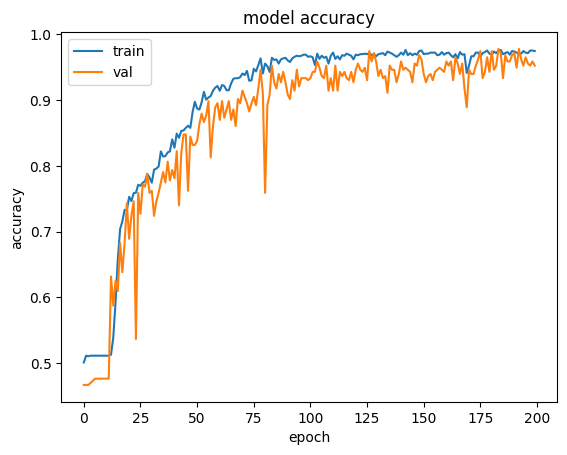

In [108]:
plt.plot(history.history["accuracy"] +
history1.history["accuracy"] +
history2.history["accuracy"] +
history3.history["accuracy"] +
history4.history["accuracy"] +
history5.history["accuracy"] +
history6.history["accuracy"] +
history7.history["accuracy"] +
history8.history["accuracy"] +
history9.history["accuracy"] +
history10.history["accuracy"] +
history11.history["accuracy"] +
history12.history["accuracy"] +
history13.history["accuracy"] +
history14.history["accuracy"] +
history15.history["accuracy"] +
history16.history["accuracy"] +
history17.history["accuracy"] +
history18.history["accuracy"] +
history19.history["accuracy"] +
history20.history["accuracy"] +
history21.history["accuracy"] +
history22.history["accuracy"] +
history23.history["accuracy"] +
history24.history["accuracy"] +
history25.history["accuracy"] +
history26.history["accuracy"] +
history27.history["accuracy"] +
history28.history["accuracy"] +
history29.history["accuracy"] +
history30.history["accuracy"] +
history31.history["accuracy"] +
history32.history["accuracy"])



plt.plot(history.history["val_accuracy"] +
history1.history["val_accuracy"] +
history2.history["val_accuracy"] +
history3.history["val_accuracy"] +
history4.history["val_accuracy"] +
history5.history["val_accuracy"] +
history6.history["val_accuracy"] +
history7.history["val_accuracy"] +
history8.history["val_accuracy"] +
history9.history["val_accuracy"] +
history10.history["val_accuracy"] +
history11.history["val_accuracy"] +
history12.history["val_accuracy"] +
history13.history["val_accuracy"] +
history14.history["val_accuracy"] +
history15.history["val_accuracy"] +
history16.history["val_accuracy"] +
history17.history["val_accuracy"] +
history18.history["val_accuracy"] +
history19.history["val_accuracy"] +
history20.history["val_accuracy"] +
history21.history["val_accuracy"] +
history22.history["val_accuracy"] +
history23.history["val_accuracy"] +
history24.history["val_accuracy"] +
history25.history["val_accuracy"] +
history26.history["val_accuracy"] +
history27.history["val_accuracy"] +
history28.history["val_accuracy"] +
history29.history["val_accuracy"] +
history30.history["val_accuracy"] +
history31.history["val_accuracy"] +
history32.history["val_accuracy"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

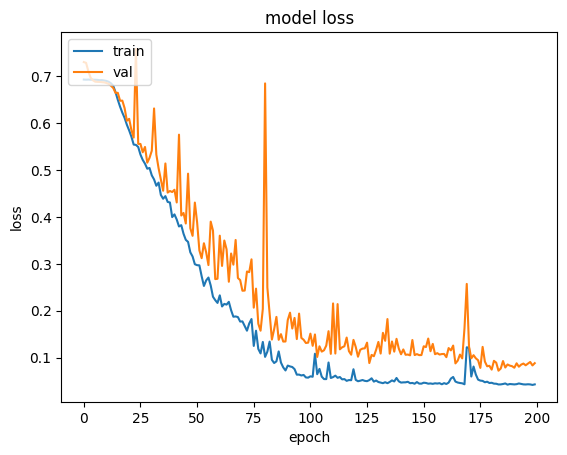

In [109]:
plt.plot(history.history["loss"] +
history1.history["loss"] +
history2.history["loss"] +
history3.history["loss"] +
history4.history["loss"] +
history5.history["loss"] +
history6.history["loss"] +
history7.history["loss"] +
history8.history["loss"] +
history9.history["loss"] +
history10.history["loss"] +
history11.history["loss"] +
history12.history["loss"] +
history13.history["loss"] +
history14.history["loss"] +
history15.history["loss"] +
history16.history["loss"] +
history17.history["loss"] +
history18.history["loss"] +
history19.history["loss"] +
history20.history["loss"] +
history21.history["loss"] +
history22.history["loss"] +
history23.history["loss"] +
history24.history["loss"] +
history25.history["loss"] +
history26.history["loss"] +
history27.history["loss"] +
history28.history["loss"] +
history29.history["loss"] +
history30.history["loss"] +
history31.history["loss"] +
history32.history["loss"])


plt.plot(history.history["val_loss"] +
history1.history["val_loss"] +
history2.history["val_loss"] +
history3.history["val_loss"] +
history4.history["val_loss"] +
history5.history["val_loss"] +
history6.history["val_loss"] +
history7.history["val_loss"] +
history8.history["val_loss"] +
history9.history["val_loss"] +
history10.history["val_loss"] +
history11.history["val_loss"] +
history12.history["val_loss"] +
history13.history["val_loss"] +
history14.history["val_loss"] +
history15.history["val_loss"] +
history16.history["val_loss"] +
history17.history["val_loss"] +
history18.history["val_loss"] +
history19.history["val_loss"] +
history20.history["val_loss"] +
history21.history["val_loss"] +
history22.history["val_loss"] +
history23.history["val_loss"] +
history24.history["val_loss"] +
history25.history["val_loss"] +
history26.history["val_loss"] +
history27.history["val_loss"] +
history28.history["val_loss"] +
history29.history["val_loss"] +
history30.history["val_loss"] +
history31.history["val_loss"] +
history32.history["val_loss"])


plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

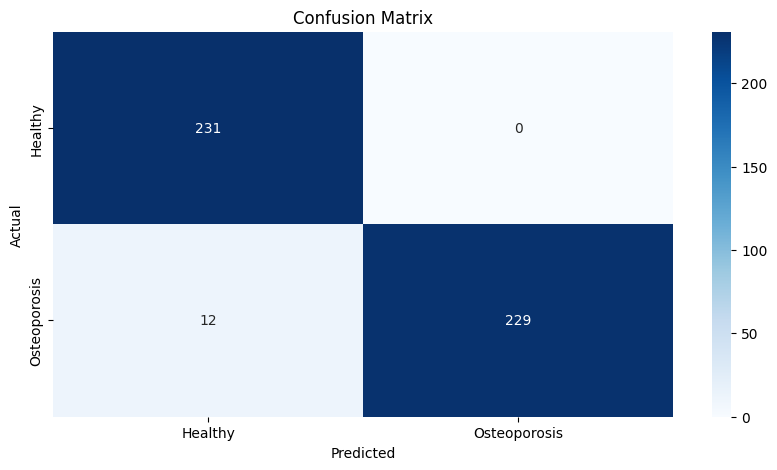

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Healthy','Osteoporosis']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred2)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()
